In [3]:
#Run this first cell to define all main paths. Then either jump to the postprocessing windows near
#the end or run the unet segmentation cells (just after this cell) in case you need it.

#Set this to true only if you want to obtain cyst segmentations from manually corrected kidney masks,
#not running unet segmentation, but just the postprocessing part. Set it to false to do the whole 
#processing from the original Unet masks
manually_corr_kidneysMask = True


from glob import glob as glob

#Folder with the original image as an image sequence. It can be changed to your folder of choice
Data_folders = glob('E:/AAV para enfermedades renales/CT/Tanda 5 (2021-2022)/*/*')
#Data_folders = glob('E:/AAV para enfermedades renales/CT/Tanda 7 (2022-2023)/*/*')



#Data_folders = 'D:/AAV para enfermedades renales/Imágenes de CT y MR/CT/Pathologic/4 - 10DIC21-PCKD+1control/'+\
#'TROPISMORENAL_RATON5_2I_10DIC21_10Dec2021_Acq001_ring/TROPISMORENAL_RATON5_2I_10DIC21_10Dec2021_Acq001_ring'

#Data_folder = 'D:/AAV para enfermedades renales/Imágenes de CT y MR/Unet2D (CT)/'+\
#'inference/TROPISMORENAL_RATON6_1D1I_23DIC21_23Dec2021_Acq001_ring-Results'


#Folder where the segmented masks of 2D images obtained with Unet will be saved. Also a 
#.tif stack with the same name as the folder will be created, with the mask after binarization
#and connected components analysis.

#Define the general results folder. 
Results_folders = 'E:/AAV para enfermedades renales/Imagenes de CT y MR/Unet2D (CT)/inference'
#Results_folders = 'E:/AAV para enfermedades renales/Imagenes de CT y MR/Unet2D (CT)/inference'+\
#'/0-Alternative_cyst_segmentationTanda7'

#Path to the folder with the model to be used on the Unet
Prediction_model_folder = 'D:/AAV para enfermedades renales/Imágenes de CT y MR/Unet2D (CT)/models/'+\
'cysts4-Imagenet-pretrained(fromEpoch134)'

#Threshold to binarize the initial segmentation.
threshold = 112

#Radius for the circular kernel of the closing operation after connected components
radiusClosing = 4

#Radius to slightly erode the borders of the kidney mask, too extended

radiusErosion = 3
#radiusErosion = 0

#If you are extracting cysts from manually corrected kidney masks, the kidney masks should be in the
#same folder as the corresponding image. The output image for the cyst masks will also be there.

    

slice1 = 252

import os
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cc3d
import cv2
import scipy
from scipy import ndimage
#import skimage
import skimage.feature as feature
import skimage.segmentation as segmentation
#Voxel size for the images to be analyzed [Z,X,Y]
voxelSize = np.array([0.122,0.122,0.122])
print(Data_folders)

['E:/AAV para enfermedades renales/CT/Tanda 5 (2021-2022)\\01 - 26NOV21-PCKD+1control\\TROPISMORENAL_RATON2_1D_26NOV21_26Nov2021_Acq001_ring', 'E:/AAV para enfermedades renales/CT/Tanda 5 (2021-2022)\\01 - 26NOV21-PCKD+1control\\TROPISMORENAL_RATON3_1I_26NOV21_26Nov2021_Acq001_ring']


In [2]:
#In case you want to run the unet,
#Load Unet2 dependencies. Otherwise don't run

Notebook_version = '1.13'
Network = 'U-Net (2D)'


from builtins import any as b_any

def get_requirements_path():
    # Store requirements file in 'contents' directory 
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path, delimiter = "\n")
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list] 
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item + '\n')

    file.close()

import sys
before = [str(m) for m in sys.modules]

#@markdown ##Load key U-Net dependencies

#As this notebokk depends mostly on keras which runs a tensorflow backend (which in turn is pre-installed in colab)
#only the data library needs to be additionally installed.
#%tensorflow_version 1.x
import tensorflow as tf
# print(tensorflow.__version__)
# print("Tensorflow enabled.")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import segmentation_models
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Keras imports
from keras import models
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger # we currently don't use any other callbacks from ModelCheckpoints
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as keras

# General import
import numpy as np
import pandas as pd
import os
from skimage import img_as_ubyte, io, transform
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
from pathlib import Path
import shutil
import random
import time
import csv
import sys
from math import ceil
from fpdf import FPDF, HTMLMixin
from pip._internal.operations.freeze import freeze
import subprocess
# Imports for QC
from PIL import Image
from scipy import signal
from scipy import ndimage
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr

# For sliders and dropdown menu and progress bar
from ipywidgets import interact
import ipywidgets as widgets
# from tqdm import tqdm
from tqdm.notebook import tqdm

from sklearn.feature_extraction import image
from skimage import img_as_ubyte, io, transform
from skimage.util.shape import view_as_windows

from datetime import datetime


# Suppressing some warnings
import warnings
warnings.filterwarnings('ignore')




def create_patches(Training_source, Training_target, patch_width, patch_height, min_fraction):
  """
  Function creates patches from the Training_source and Training_target images. 
  The steps parameter indicates the offset between patches and, if integer, is the same in x and y.
  Saves all created patches in two new directories in the /content folder.

  min_fraction is the minimum fraction of pixels that need to be foreground to be considered as a valid patch

  Returns: - Two paths to where the patches are now saved
  """
  DEBUG = False

  Patch_source = os.path.join('/content','img_patches')
  Patch_target = os.path.join('/content','mask_patches')
  Patch_rejected = os.path.join('/content','rejected')
  

  #Here we save the patches, in the /content directory as they will not usually be needed after training
  if os.path.exists(Patch_source):
    shutil.rmtree(Patch_source)
  if os.path.exists(Patch_target):
    shutil.rmtree(Patch_target)
  if os.path.exists(Patch_rejected):
    shutil.rmtree(Patch_rejected)

  os.mkdir(Patch_source)
  os.mkdir(Patch_target)
  os.mkdir(Patch_rejected) #This directory will contain the images that have too little signal.
  
  patch_num = 0

  for file in tqdm(os.listdir(Training_source)):

    img = io.imread(os.path.join(Training_source, file))
    mask = io.imread(os.path.join(Training_target, file),as_gray=True)

    if DEBUG:
      print(file)
      print(img.dtype)

    # Using view_as_windows with step size equal to the patch size to ensure there is no overlap
    patches_img = view_as_windows(img, (patch_width, patch_height), (patch_width, patch_height))
    patches_mask = view_as_windows(mask, (patch_width, patch_height), (patch_width, patch_height))

    patches_img = patches_img.reshape(patches_img.shape[0]*patches_img.shape[1], patch_width,patch_height)
    patches_mask = patches_mask.reshape(patches_mask.shape[0]*patches_mask.shape[1], patch_width,patch_height)

    if DEBUG:
      print(all_patches_img.shape)
      print(all_patches_img.dtype)

    for i in range(patches_img.shape[0]):
      img_save_path = os.path.join(Patch_source,'patch_'+str(patch_num)+'.tif')
      mask_save_path = os.path.join(Patch_target,'patch_'+str(patch_num)+'.tif')
      patch_num += 1

      # if the mask conatins at least 2% of its total number pixels as mask, then go ahead and save the images
      pixel_threshold_array = sorted(patches_mask[i].flatten())
      if pixel_threshold_array[int(round(len(pixel_threshold_array)*(1-min_fraction)))]>0:
        io.imsave(img_save_path, img_as_ubyte(normalizeMinMax(patches_img[i])))
        io.imsave(mask_save_path, convert2Mask(normalizeMinMax(patches_mask[i]),0))
      else:
        io.imsave(Patch_rejected+'/patch_'+str(patch_num)+'_image.tif', img_as_ubyte(normalizeMinMax(patches_img[i])))
        io.imsave(Patch_rejected+'/patch_'+str(patch_num)+'_mask.tif', convert2Mask(normalizeMinMax(patches_mask[i]),0))

  return Patch_source, Patch_target


def estimatePatchSize(data_path, max_width = 512, max_height = 512):

  files = os.listdir(data_path)
  
  # Get the size of the first image found in the folder and initialise the variables to that
  n = 0 
  while os.path.isdir(os.path.join(data_path, files[n])):
    n += 1
  (height_min, width_min) = Image.open(os.path.join(data_path, files[n])).size

  # Screen the size of all dataset to find the minimum image size
  for file in files:
    if not os.path.isdir(os.path.join(data_path, file)):
      (height, width) = Image.open(os.path.join(data_path, file)).size
      if width < width_min:
        width_min = width
      if height < height_min:
        height_min = height
  
  # Find the power of patches that will fit within the smallest dataset
  width_min, height_min = (fittingPowerOfTwo(width_min), fittingPowerOfTwo(height_min))

  # Clip values at maximum permissible values
  if width_min > max_width:
    width_min = max_width

  if height_min > max_height:
    height_min = max_height
  
  return (width_min, height_min)

def fittingPowerOfTwo(number):
  n = 0
  while 2**n <= number:
    n += 1 
  return 2**(n-1)


def getClassWeights(Training_target_path):

  Mask_dir_list = os.listdir(Training_target_path)
  number_of_dataset = len(Mask_dir_list)

  class_count = np.zeros(2, dtype=int)
  for i in tqdm(range(number_of_dataset)):
    print(Mask_dir_list[i])
    mask = io.imread(os.path.join(Training_target_path, Mask_dir_list[i]))
    mask = normalizeMinMax(mask)
    class_count[0] += mask.shape[0]*mask.shape[1] - mask.sum()
    class_count[1] += mask.sum()

  n_samples = class_count.sum()
  n_classes = 2

  class_weights = n_samples / (n_classes * class_count)
  return class_weights

def weighted_binary_crossentropy(class_weights):

    def _weighted_binary_crossentropy(y_true, y_pred):
        binary_crossentropy = keras.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * class_weights[1] + (1. - y_true) * class_weights[0]
        weighted_binary_crossentropy = weight_vector * binary_crossentropy

        return keras.mean(weighted_binary_crossentropy)

    return _weighted_binary_crossentropy


def save_augment(datagen,orig_img,dir_augmented_data="/content/augment"):
  """
  Saves a subset of the augmented data for visualisation, by default in /content.

  This is adapted from: https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
  
  """
  try:
    os.mkdir(dir_augmented_data)
  except:
        ## if the preview folder exists, then remove
        ## the contents (pictures) in the folder
    for item in os.listdir(dir_augmented_data):
      os.remove(dir_augmented_data + "/" + item)

    ## convert the original image to array
  x = img_to_array(orig_img)
    ## reshape (Sampke, Nrow, Ncol, 3) 3 = R, G or B
    #print(x.shape)
  x = x.reshape((1,) + x.shape)
    #print(x.shape)
    ## -------------------------- ##
    ## randomly generate pictures
    ## -------------------------- ##
  i = 0
    #We will just save 5 images,
    #but this can be changed, but note the visualisation in 3. currently uses 5.
  Nplot = 5
  for batch in datagen.flow(x,batch_size=1,
                            save_to_dir=dir_augmented_data,
                            save_format='tif',
                            seed=42):
    i += 1
    if i > Nplot - 1:
      break

# Generators
def buildDoubleGenerator(image_datagen, mask_datagen, image_folder_path, mask_folder_path, subset, batch_size, target_size):
  '''
  Can generate image and mask at the same time use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
  
  datagen: ImageDataGenerator 
  subset: can take either 'training' or 'validation'
  '''
  seed = 1
  image_generator = image_datagen.flow_from_directory(
      os.path.dirname(image_folder_path),
      classes = [os.path.basename(image_folder_path)],
      class_mode = None,
      color_mode = "grayscale",
      target_size = target_size,
      batch_size = batch_size,
      subset = subset,
      interpolation = "bicubic",
      seed = seed)
  
  mask_generator = mask_datagen.flow_from_directory(
      os.path.dirname(mask_folder_path),
      classes = [os.path.basename(mask_folder_path)],
      class_mode = None,
      color_mode = "grayscale",
      target_size = target_size,
      batch_size = batch_size,
      subset = subset,
      interpolation = "nearest",
      seed = seed)
  
  this_generator = zip(image_generator, mask_generator)
  for (img,mask) in this_generator:
      # img,mask = adjustData(img,mask)
      yield (img,mask)


def prepareGenerators(image_folder_path, mask_folder_path, datagen_parameters, batch_size = 4, target_size = (512, 512)):
  image_datagen = ImageDataGenerator(**datagen_parameters, preprocessing_function = normalizePercentile)
  mask_datagen = ImageDataGenerator(**datagen_parameters, preprocessing_function = normalizeMinMax)

  train_datagen = buildDoubleGenerator(image_datagen, mask_datagen, image_folder_path, mask_folder_path, 'training', batch_size, target_size)
  validation_datagen = buildDoubleGenerator(image_datagen, mask_datagen, image_folder_path, mask_folder_path, 'validation', batch_size, target_size)

  return (train_datagen, validation_datagen)


# Normalization functions from Martin Weigert
def normalizePercentile(x, pmin=1, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):#dtype=np.float32
    """This function is adapted from Martin Weigert"""
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x



# Simple normalization to min/max fir the Mask
def normalizeMinMax(x, dtype=np.float32):
  x = x.astype(dtype,copy=False)
  x = (x - np.amin(x)) / (np.amax(x) - np.amin(x))
  return x


# This is code outlines the architecture of U-net. The choice of pooling steps decides the depth of the network. 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def unet(pretrained_weights = None, input_size = (256,256,1), pooling_steps = 4, learning_rate = 1e-4, verbose=True, class_weights=np.ones(2)):
    
    print('----Unet Definition----')

    base_model = segmentation_models.Unet('resnet34',encoder_weights='imagenet')

    print('base model.summary()')
    base_model.summary()

    inp = Input(shape=input_size)
    print('inp: ',inp)
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    print('l1: ',l1)
    out = base_model(l1)
    print('out: ',out)
    model = Model(inp, out, name=base_model.name)

    # model.compile(optimizer = Adam(lr = learning_rate), loss = 'binary_crossentropy', metrics = ['acc'])
    model.compile(optimizer = Adam(lr = learning_rate), loss = weighted_binary_crossentropy(class_weights))


    if verbose:
      model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights);

    return model

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def predict_as_tiles(Image_path, model):

  # Read the data in and normalize
  Image_raw = io.imread(Image_path, as_gray = True)
  Image_raw = normalizePercentile(Image_raw)

  # Get the patch size from the input layer of the model
  patch_size = model.layers[0].output_shape[0][1:3]

  # Pad the image with zeros if any of its dimensions is smaller than the patch size
  if Image_raw.shape[0] < patch_size[0] or Image_raw.shape[1] < patch_size[1]:
    Image = np.zeros((max(Image_raw.shape[0], patch_size[0]), max(Image_raw.shape[1], patch_size[1])))
    Image[0:Image_raw.shape[0], 0: Image_raw.shape[1]] = Image_raw
  else:
    Image = Image_raw

  # Calculate the number of patches in each dimension
  n_patch_in_width = ceil(Image.shape[0]/patch_size[0])
  n_patch_in_height = ceil(Image.shape[1]/patch_size[1])

  prediction = np.zeros(Image.shape)

  for x in range(n_patch_in_width):
    for y in range(n_patch_in_height):
      xi = patch_size[0]*x
      yi = patch_size[1]*y

      # If the patch exceeds the edge of the image shift it back 
      if xi+patch_size[0] >= Image.shape[0]:
        xi = Image.shape[0]-patch_size[0]

      if yi+patch_size[1] >= Image.shape[1]:
        yi = Image.shape[1]-patch_size[1]
      
      # Extract and reshape the patch
      patch = Image[xi:xi+patch_size[0], yi:yi+patch_size[1]]
      patch = np.reshape(patch,patch.shape+(1,))
      patch = np.reshape(patch,(1,)+patch.shape)

      # Get the prediction from the patch and paste it in the prediction in the right place
      predicted_patch = model.predict(patch, batch_size = 1)
      prediction[xi:xi+patch_size[0], yi:yi+patch_size[1]] = np.squeeze(predicted_patch)


  return prediction[0:Image_raw.shape[0], 0: Image_raw.shape[1]]
  



def saveResult(save_path, nparray, source_dir_list, prefix='', threshold=None):
  for (filename, image) in zip(source_dir_list, nparray):
      io.imsave(os.path.join(save_path, prefix+os.path.splitext(filename)[0]+'.tif'), img_as_ubyte(image)) # saving as unsigned 8-bit image
      
      # For masks, threshold the images and return 8 bit image
      if threshold is not None:
        mask = convert2Mask(image, threshold)
        io.imsave(os.path.join(save_path, prefix+'mask_'+os.path.splitext(filename)[0]+'.tif'), mask)


def convert2Mask(image, threshold):
  mask = img_as_ubyte(image, force_copy=True)
  mask[mask > threshold] = 255
  mask[mask <= threshold] = 0
  return mask


def getIoUvsThreshold(prediction_filepath, groud_truth_filepath):
  prediction = io.imread(prediction_filepath)
  ground_truth_image = img_as_ubyte(io.imread(groud_truth_filepath, as_gray=True), force_copy=True)

  threshold_list = []
  IoU_scores_list = []

  for threshold in range(0,256): 
    # Convert to 8-bit for calculating the IoU
    mask = img_as_ubyte(prediction, force_copy=True)
    mask[mask > threshold] = 255
    mask[mask <= threshold] = 0

    # Intersection over Union metric
    intersection = np.logical_and(ground_truth_image, np.squeeze(mask))
    union = np.logical_or(ground_truth_image, np.squeeze(mask))
    iou_score = np.sum(intersection) / np.sum(union)

    threshold_list.append(threshold)
    IoU_scores_list.append(iou_score)

  return (threshold_list, IoU_scores_list)



# -------------- Other definitions -----------
W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red
prediction_prefix = 'Predicted_'


print('-------------------')
print('U-Net and dependencies installed.')

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'

# Check if this is the latest version of the notebook

All_notebook_versions = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_Notebook_versions.csv", dtype=str)
print('Notebook version: '+Notebook_version)
Latest_Notebook_version = All_notebook_versions[All_notebook_versions["Notebook"] == Network]['Version'].iloc[0]
print('Latest notebook version: '+Latest_Notebook_version)
if Notebook_version == Latest_Notebook_version:
  print("This notebook is up-to-date.")
else:
  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")


def pdf_export(trained = False, augmentation = False, pretrained_model = False):
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 




  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Training report for '+Network+' model ('+model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 
    
  # add another cell 
  if trained:
    training_time = "Training time: "+str(hour)+ "hour(s) "+str(mins)+"min(s) "+str(round(sec))+"sec(s)"
    pdf.cell(190, 5, txt = training_time, ln = 1, align='L')
  pdf.ln(1)

  Header_2 = 'Information for your materials and method:'
  pdf.cell(190, 5, txt=Header_2, ln=1, align='L')

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '
  #print(all_packages)

  #Main Packages
  main_packages = ''
  version_numbers = []
  for name in ['tensorflow','numpy','Keras']:
    find_name=all_packages.find(name)
    main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
    #Version numbers only here:
    version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

  cuda_version = subprocess.run('nvcc --version',stdout=subprocess.PIPE, shell=True)
  cuda_version = cuda_version.stdout.decode('utf-8')
  cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
  gpu_name = subprocess.run('nvidia-smi',stdout=subprocess.PIPE, shell=True)
  gpu_name = gpu_name.stdout.decode('utf-8')
  gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]
  #print(cuda_version[cuda_version.find(', V')+3:-1])
  #print(gpu_name)
  loss = str(model.loss)[str(model.loss).find('function')+len('function'):str(model.loss).find('.<')]
  shape = io.imread(Training_source+'/'+os.listdir(Training_source)[1]).shape
  dataset_size = len(os.listdir(Training_source))

  text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(number_of_training_dataset)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_width)+','+str(patch_height)+')) with a batch size of '+str(batch_size)+' and a'+loss+' loss function,'+' using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

  if pretrained_model:
    text = 'The '+Network+' model was trained for '+str(number_of_epochs)+' epochs on '+str(number_of_training_dataset)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_width)+','+str(patch_height)+')) with a batch size of '+str(batch_size)+'  and a'+loss+' loss function,'+' using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). The model was re-trained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

  pdf.set_font('')
  pdf.set_font_size(10.)
  pdf.multi_cell(180, 5, txt = text, align='L')
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(1)
  pdf.cell(28, 5, txt='Augmentation: ', ln=1)
  pdf.set_font('')
  if augmentation:
    aug_text = 'The dataset was augmented by'
    if rotation_range != 0:
      aug_text = aug_text+'\n- rotation'
    if horizontal_flip == True or vertical_flip == True:
      aug_text = aug_text+'\n- flipping'
    if zoom_range != 0:
      aug_text = aug_text+'\n- random zoom magnification'
    if horizontal_shift != 0 or vertical_shift != 0:
      aug_text = aug_text+'\n- shifting'
    if shear_range != 0:
      aug_text = aug_text+'\n- image shearing'
  else:
    aug_text = 'No augmentation was used for training.'
  pdf.multi_cell(190, 5, txt=aug_text, align='L')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Parameters', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  if Use_Default_Advanced_Parameters:
    pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
  pdf.cell(200, 5, txt='The following parameters were used for training:')
  pdf.ln(1)
  html = """ 
  <table width=40% style="margin-left:0px;">
    <tr>
      <th width = 50% align="left">Parameter</th>
      <th width = 50% align="left">Value</th>
    </tr>
    <tr>
      <td width = 50%>number_of_epochs</td>
      <td width = 50%>{0}</td>
    </tr>
    <tr>
      <td width = 50%>patch_size</td>
      <td width = 50%>{1}</td>
    </tr>
    <tr>
      <td width = 50%>batch_size</td>
      <td width = 50%>{2}</td>
    </tr>
    <tr>
      <td width = 50%>number_of_steps</td>
      <td width = 50%>{3}</td>
    </tr>
    <tr>
      <td width = 50%>percentage_validation</td>
      <td width = 50%>{4}</td>
    </tr>
    <tr>
      <td width = 50%>initial_learning_rate</td>
      <td width = 50%>{5}</td>
    </tr>
    <tr>
      <td width = 50%>pooling_steps</td>
      <td width = 50%>{6}</td>
    </tr>
    <tr>
      <td width = 50%>min_fraction</td>
      <td width = 50%>{7}</td>
  </table>
  """.format(number_of_epochs, str(patch_width)+'x'+str(patch_height), batch_size, number_of_steps, percentage_validation, initial_learning_rate, pooling_steps, min_fraction)
  pdf.write_html(html)

  #pdf.multi_cell(190, 5, txt = text_2, align='L')
  pdf.set_font("Arial", size = 11, style='B')
  pdf.ln(1)
  pdf.cell(190, 5, txt = 'Training Dataset', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(29, 5, txt= 'Training_source:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_source, align = 'L')
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(28, 5, txt= 'Training_target:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_target, align = 'L')
  #pdf.cell(190, 5, txt=aug_text, align='L', ln=1)
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(21, 5, txt= 'Model Path:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
  pdf.ln(1)
  pdf.cell(60, 5, txt = 'Example Training pair', ln=1)
  pdf.ln(1)
  exp_size = io.imread('/content/TrainingDataExample_Unet2D.png').shape
  pdf.image('/content/TrainingDataExample_Unet2D.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  pdf.ln(1)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- Unet: Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')
  # if Use_Data_augmentation:
  #   ref_3 = '- Augmentor: Bloice, Marcus D., Christof Stocker, and Andreas Holzinger. "Augmentor: an image augmentation library for machine learning." arXiv preprint arXiv:1708.04680 (2017).'
  #   pdf.multi_cell(190, 5, txt = ref_3, align='L')
  pdf.ln(3)
  reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(model_path+'/'+model_name+'/'+model_name+'_training_report.pdf')

  print('------------------------------')
  print('PDF report exported in '+model_path+'/'+model_name+'/')

def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'Unet 2D'

  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Loss curves', ln=1, align='L')
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  if os.path.exists(full_QC_model_path+'/Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'/Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/12), h = round(exp_size[0]/3))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.',align='L')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Threshold Optimisation', ln=1, align='L')
  #pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/'+QC_model_name+'_IoUvsThresholdPlot.png').shape
  pdf.image(full_QC_model_path+'/Quality Control/'+QC_model_name+'_IoUvsThresholdPlot.png', x = 11, y = None, w = round(exp_size[1]/6), h = round(exp_size[0]/7))
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'/Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="10" face="Courier New" >
  <table width=60% style="margin-left:0px;">"""
  with open(full_QC_model_path+'/Quality Control/QC_metrics_'+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    image = header[0]
    IoU = header[1]
    IoU_OptThresh = header[2]
    header = """
    <tr>
    <th width = 33% align="center">{0}</th>
    <th width = 33% align="center">{1}</th>
    <th width = 33% align="center">{2}</th>
    </tr>""".format(image,IoU,IoU_OptThresh)
    html = html+header
    i=0
    for row in metrics:
      i+=1
      image = row[0]
      IoU = row[1]
      IoU_OptThresh = row[2]
      cells = """
        <tr>
          <td width = 33% align="center">{0}</td>
          <td width = 33% align="center">{1}</td>
          <td width = 33% align="center">{2}</td>
        </tr>""".format(image,str(round(float(IoU),3)),str(round(float(IoU_OptThresh),3)))
      html = html+cells
    html = html+"""</body></table>"""
    
  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- Unet: Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(full_QC_model_path+'/Quality Control/'+QC_model_name+'_QC_report.pdf')

  print('------------------------------')
  print('QC PDF report exported as '+full_QC_model_path+'/Quality Control/'+QC_model_name+'_QC_report.pdf')

# Build requirements file for local run
after = [str(m) for m in sys.modules]
build_requirements_file(before, after)

Segmentation Models: using `keras` framework.
-------------------
U-Net and dependencies installed.
Notebook version: 1.13
Latest notebook version: 1.13
This notebook is up-to-date.


In [3]:
#Apply the unet to the data, otherwise don't run.

for count,Data_folder in enumerate(Data_folders):
    
    #Fill the name of the folder to correctly get the images
    Data_folder = Data_folder + '/' + os.path.basename(Data_folder)
    Results_folder = Results_folders+'/'+ os.path.basename(Data_folder)+'-Results'
    
    os.makedirs(Results_folder)
    #Run the Unet on the images

    # ------------- Initial user input ------------
    #@markdown ###Provide the path to your dataset and to the folder where the prediction will be saved (Result folder), then play the cell to predict output on your unseen images.


    #@markdown ###Do you want to use the current trained model?
    Use_the_current_trained_model = False #@param {type:"boolean"}

    #@markdown ###If not, please provide the path to the model folder:


    #Here we find the loaded model name and parent path
    Prediction_model_name = os.path.basename(Prediction_model_folder)
    Prediction_model_path = os.path.dirname(Prediction_model_folder)


    # ------------- Failsafes ------------
    if (Use_the_current_trained_model): 
      print("Using current trained network")
      Prediction_model_name = model_name
      Prediction_model_path = model_path

    full_Prediction_model_path = os.path.join(Prediction_model_path, Prediction_model_name)
    if os.path.exists(full_Prediction_model_path):
      print("The "+Prediction_model_name+" network will be used.")
    else:
      print(R+'!! WARNING: The chosen model does not exist !!'+W)
      print('Please make sure you provide a valid model path and model name before proceeding further.')


    # ------------- Prepare the model and run predictions ------------

    # Load the model and prepare generator



    unet = load_model(os.path.join(Prediction_model_path, Prediction_model_name, 'weights_best.hdf5'), custom_objects={'_weighted_binary_crossentropy': weighted_binary_crossentropy(np.ones(2))})
    Input_size = unet.layers[0].output_shape[0][1:3]
    print('Model input size: '+str(Input_size[0])+'x'+str(Input_size[1]))

    # Create a list of sources
    source_dir_list = os.listdir(Data_folder)
    print(source_dir_list)
    number_of_dataset = len(source_dir_list)
    print('Number of dataset found in the folder: '+str(number_of_dataset))

    predictions = []
    for i in tqdm(range(number_of_dataset)):
      predictions.append(predict_as_tiles(os.path.join(Data_folder, source_dir_list[i]), unet))
      # predictions.append(prediction(os.path.join(Data_folder, source_dir_list[i]), os.path.join(Prediction_model_path, Prediction_model_name)))


    # Save the results in the folder along with the masks according to the set threshold
    saveResult(Results_folder, predictions, source_dir_list, prefix=prediction_prefix, threshold=None)


    # ------------- For display ------------
    print('--------------------------------------------------------------')


    def show_prediction_mask(file=os.listdir(Data_folder), threshold=(0,255,1)):

      plt.figure(figsize=(18,6))
      # Wide-field
      plt.subplot(1,3,1)
      plt.axis('off')
      img_Source = plt.imread(os.path.join(Data_folder, file))
      plt.imshow(img_Source, cmap='gray')
      plt.title('Source image',fontsize=15)
      # Prediction
      plt.subplot(1,3,2)
      plt.axis('off')
      img_Prediction = plt.imread(os.path.join(Results_folder, prediction_prefix+file))
      plt.imshow(img_Prediction, cmap='gray')
      plt.title('Prediction',fontsize=15)

      # Thresholded mask
      plt.subplot(1,3,3)
      plt.axis('off')
      img_Mask = convert2Mask(img_Prediction, threshold)
      plt.imshow(img_Mask, cmap='gray')
      plt.title('Mask (Threshold: '+str(round(threshold))+')',fontsize=15)


    #interact(show_prediction_mask, continuous_update=True);



The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0000.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0001.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0002.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0003.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0004.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0005.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0006.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0007.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0008.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0009.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0010.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0011.tif', 'TropismoRenal_2020_raton1D_25jun21_25Jun2021_Acq001_ring0012.tif', 'TropismoRenal_2020_ra

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0000.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0001.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0002.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0003.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0004.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0005.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0006.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0007.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0008.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0009.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0010.tif', 'TropismoRenal_2020_raton1I_25jun21_25Jun2021_Acq001_ring0011.tif', 'TropismoRenal_2020_raton1I

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0000.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0001.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0002.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0003.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0004.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0005.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0006.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0007.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0008.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0009.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0010.tif', 'TROPISMORENAL_2020_RATON2D_25JUN21_25Jun2021_Acq001_ring0011.tif', 'TROPISMORENAL_2020_RATON2D

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0000.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0001.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0002.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0003.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0004.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0005.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0006.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0007.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0008.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0009.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0010.tif', 'TROPISMORENAL_2020_RATON2I_25JUN21_25Jun2021_Acq001_ring0011.tif', 'TROPISMORENAL_2020_RATON2I

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0000.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0001.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0002.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0003.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0004.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0005.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0006.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0007.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0008.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0009.tif', 'TROPISMORENAL_2020_RATON_CONTROL_25JUN21_25Jun2021_Acq001_ring0010.tif', 'TROPISMORENAL_2020_RATON_CON

  0%|          | 0/476 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0000.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0001.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0002.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0003.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0004.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0005.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0006.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0007.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0008.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0009.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0010.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0011.tif', 'TROPISMORENAL_RATON_1D_13JUL21_13Jul2021_Acq001_ring0012.tif', 'TROPISMORE

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0000.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0001.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0002.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0003.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0004.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0005.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0006.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0007.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0008.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0009.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0010.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0011.tif', 'TROPISMORENAL_RATON_1I_13JUL21_13Jul2021_Acq001_ring0012.tif', 'TROPISMORE

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0000.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0001.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0002.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0003.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0004.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0005.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0006.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0007.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0008.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0009.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0010.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0011.tif', 'TROPISMORENAL_RATON_2D_13JUL21_13Jul2021_Acq001_ring0012.tif', 'TROPISMORE

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0000.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0001.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0002.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0003.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0004.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0005.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0006.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0007.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0008.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0009.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0010.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0011.tif', 'TropismoRenal_raton_2I_13jul21_13Jul2021_Acq001_ring0012.tif', 'TropismoRe

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0000.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0001.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0002.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0003.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0004.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0005.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0006.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0007.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0008.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0009.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0010.tif', 'TROPISMORENAL_RATON_CONTROL_13JUL21_13Jul2021_Acq001_ring0011.tif', 'TROPISMORENAL_

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0000.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0001.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0002.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0003.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0004.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0005.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0006.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0007.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0008.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0009.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0010.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0011.tif', 'TROPISMORENAL_RATON_1D_28JUL21_28Jul2021_Acq001_ring0012.tif', 'TROPISMORE

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------
The cysts4-Imagenet-pretrained(fromEpoch134) network will be used.
Model input size: 512x512
['TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0000.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0001.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0002.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0003.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0004.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0005.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0006.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0007.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0008.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0009.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0010.tif', 'TROPISMORENAL_RATON_CONTROL_28JUL21_28Jul2021_Acq002_ring0011.tif', 'TROPISMORENAL_

  0%|          | 0/472 [00:00<?, ?it/s]

--------------------------------------------------------------


Diseased region analysis
imOrig3D.shape after histogram equalization:  (475, 514, 514)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
os.path.basename(Data_folder):  TROPISMORENAL_RATON2_1D_26NOV21_26Nov2021_Acq001_ring
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
THRESHOLD:  55.0
Otsu threshold applied
Full kidney mask eroded
np.min(distance):  0.0


c:\users\equipo\.conda\envs\workenvpy3.7\lib\site-packages\ipykernel_launcher.py:266: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The 3D .tif stacks have been successfully saved
Diseased region analysis
imOrig3D.shape after histogram equalization:  (475, 514, 514)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
os.path.basename(Data_folder):  TROPISMORENAL_RATON3_1I_26NOV21_26Nov2021_Acq001_ring
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
THRESHOLD:  57.0
Otsu threshold applied
Full kidney mask eroded
np.min(distance):  0.0
The 3D .tif stacks have been successfully saved


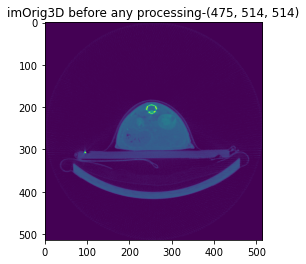

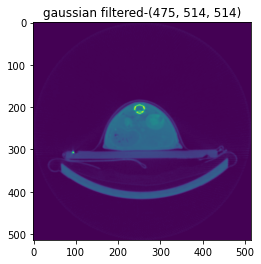

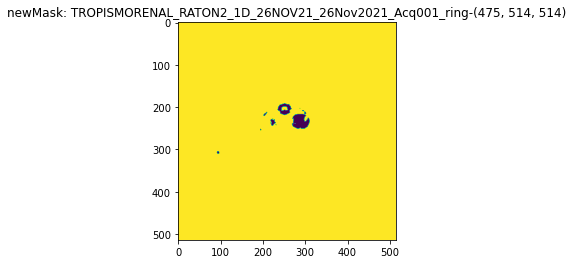

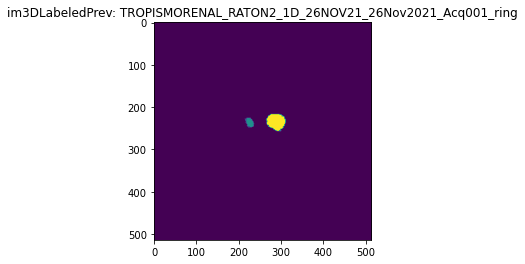

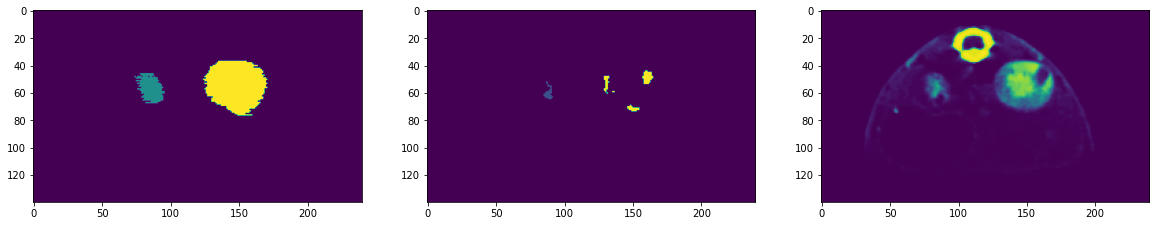

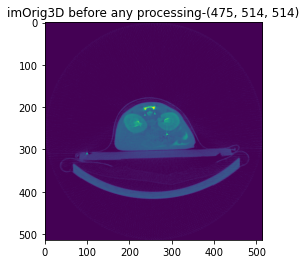

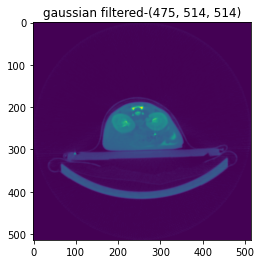

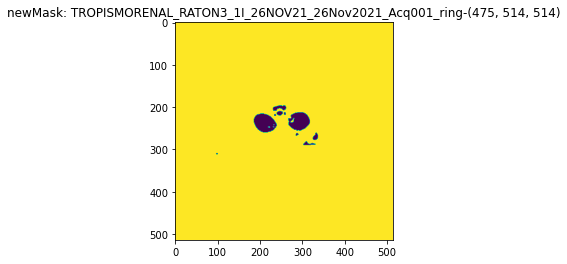

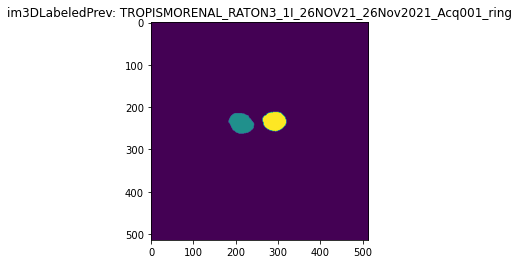

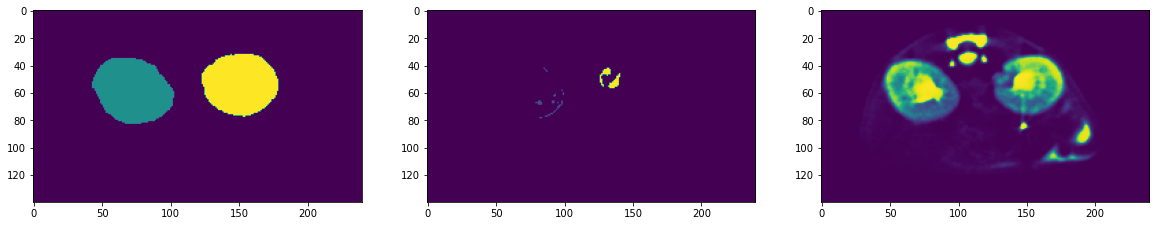

In [6]:
#Run this cell to work with manually corrected masks, 

#Alternative Image postprocessing after deep learning segmentation. 
#Different segmentation for the cysts (added options 
#to work with manually corrected masks)

thresImages = list()
thresholds = np.zeros(len(Data_folders))
numIters = 1000

for count,Data_folder in enumerate(Data_folders):
    #if  'TropismoRenal2020_raton6_5enero22_05Jan2022_Acq004_ring' in Data_folder:
    #if count<=numIters
    Data_folder = Data_folder + '/' + os.path.basename(Data_folder)
    #Fill the name of the folder to correctly get the images
    
    #If the input masks are the ones directly provided by the unet
    if not manually_corr_kidneysMask is True:
        Results_folder = Results_folders+'/'+ os.path.basename(Data_folder)+'-Results'

        #-----------------------------------------------------------------------------------------------
        #-----------------------------------------------------------------------------------------------
        #Postprocessing and volume calculations


        #This script takes as an input the folder with masks coming from applying Unet2 to kidney images.
        #It thresholds them to convert them to binary, puts them together in a single stack and 
        #postprocesses them to get rid of connected components smaller than the kidneys. Then it calculates
        #the percentage of diseased kidney.

        print('Full kidney mask refinement')
        dataPath = Results_folder

        print('dataPath: ',dataPath)

        imSlices = glob(dataPath+'/*.tif')

        #print('imSlices: ',imSlices)

        #Get dimensions from one of the images and create an empty 3D array
        sl = tiff.imread(imSlices[0])
        im3D = np.zeros([len(imSlices),sl.shape[0],sl.shape[1]],dtype=np.uint16)

        #Scan the folder through the images and save them in the array (im3D)
        for zPos,slName in enumerate(imSlices):

            sl = tiff.imread(slName)
            im3D[zPos,:,:] = sl

        print('im3D.shape: ',im3D.shape)



        #If the image is not already binary
        if len(np.unique(im3D))>2:
            print('Binarized')
            #Threshold the 3D image above half the maximum value to get a binary mask, converts it to uint8 for
            #efficiency
            print('Threshold used: ',threshold)
            im3D = np.uint8(1*(im3D>=threshold))

        #If it is binary, just take the values greater than 0
        else:
            im3D = np.uint16(1*(im3D>0))


        #Apply connected components to keep only the kidneys    
        im3DLabeled = cc3d.connected_components(im3D, connectivity=6)

        stats = cc3d.statistics(im3DLabeled)    

        voxelCounts = stats['voxel_counts']
        #Obtained the sorted indices for all connected components, sorted by size (ascending order)
        sortIndices = np.argsort(voxelCounts)

        #Remove all components but the second and third largest (the kidneys, since the largest is
        #the background)
        im3DLabeled[(im3DLabeled!=sortIndices[-2]) & (im3DLabeled!=sortIndices[-3])]=0

        #Create the binary version
        im3D = im3DLabeled
        im3D[im3D>0]=1
        im3D=np.uint16(im3D)
        
        #Morphological closing not necessary with manually corrected masks
        
        #Apply morphological closing of the specified "radius" to remove holes, slice by slice
        #kernelClosing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(radiusClosing*2+1,radiusClosing*2+1))    

        #for i in range(im3D.shape[0]):
        #    im3D[i,:,:] =  cv2.morphologyEx(im3D[i,:,:], cv2.MORPH_CLOSE, kernelClosing)    

    #On the other hand, if you want to obtain the cysts from already manually corrected masks.           
    elif manually_corr_kidneysMask is True: 
        #Here is the manually corrected kidney's mask
        dataPath = glob(os.path.dirname(Data_folder)+'/*Corrected*fullKidneysMask*.tif')[0]
        im3D=tiff.imread(dataPath)
    
    #-----------------------------------------------------------------------------
    print('Diseased region analysis')
    #Analyze the diseased region



    #Create a 3D array with the original image
    imSlices = glob(Data_folder+'/*.tif')
    sl = tiff.imread(imSlices[0])
    imOrig3D = np.zeros([len(imSlices),sl.shape[0],sl.shape[1]])

    #Scan the folder through the original images and save them in the array (imOrig3D)
    for zPos,slName in enumerate(imSlices):

        sl = tiff.imread(slName)
        imOrig3D[zPos,:,:] = sl
    
    plt.figure()
    plt.imshow(imOrig3D[slice1,:,:])
    plt.title('imOrig3D before any processing'+'-'+str(imOrig3D.shape))
        
    #imOrig3D = np.uint16(imOrig3D)   
    

    
    #plt.figure(figsize=(10,10))
    #plt.subplot(1,2,1)
    #plt.title('Original')
    #plt.imshow(imOrig3D[slice1,180:320,140:380])
    #Keep only the values inside the mask
    #tiff.imsave(dataPath+'-origNoGaussianFiltered.tif', imOrig3D)

    #Filter the image with a Gaussian kernel
    imOrig3D = scipy.ndimage.gaussian_filter(imOrig3D,sigma=1)
    
    plt.figure()
    plt.imshow(imOrig3D[slice1,:,:])
    plt.title('gaussian filtered'+'-'+str(imOrig3D.shape))
    #tiff.imsave(dataPath+'-origGaussianFiltered.tif', imOrig3D)
    
    
    maskRegion = imOrig3D[im3D>0]
    #plt.subplot(1,2,2)
    #plt.title('Filtered')
    #plt.imshow(imOrig3D[slice1,180:320,140:380])  
    #Perform histogram equalization with the segmentation's histogram
    #Keep only the values inside the mask
    maskRegion = imOrig3D[im3D>0]

    #hist,bins = np.histogram(maskRegion,bins = 256, density=True)
    hist,bins = np.histogram(maskRegion,bins = 256, density=True)
    bins = np.float16(bins)
    cdf = hist.cumsum()
    #plt.figure(figsize=(20,20))
    #plt.subplot(1,2,1)
    #plt.plot(cdf/cdf[-1], color = 'g')
    #plt.title('Cumulative distribution function of the original image (inside the kidney)'\
    #          ,color='white',fontsize=20)
    #plt.hist(cutIm.flatten(),256, color = 'r')

    imOrigNoEqualiz = imOrig3D.copy()
    shp = imOrig3D.shape

    cdf = 255 * cdf / cdf[-1]
    cdf = np.uint8(cdf)
    imOrig3D = np.interp(imOrig3D.flatten(), bins[:-1], cdf)
    imOrig3D = imOrig3D.reshape(shp)
    imOrig3D = np.uint16(imOrig3D)
    hist,bins = np.histogram(imOrig3D[im3D>0],bins = 500)
    bins = np.float16(bins)
    cdf = hist.cumsum()

    print('imOrig3D.shape after histogram equalization: ',imOrig3D.shape)
    
    #plt.subplot(1,2,2)
    #plt.plot(cdf/cdf[-1], color = 'g')
    #plt.title('Cumulative distribution function of the equalized image (inside the kidney)'\
    #          ,color='white',fontsize=20)
    #plt.hist(cutIm.flatten(),256, color = 'r')        

    maskRegion = imOrig3D[im3D>0]

    #plt.figure()
    #plt.title('Equalized histogram image')
    #plt.imshow(imOrig3D[slice1,180:320,140:380])
    #equ=equ.reshape(imOrig3D.shape)



    #Divide the kidneys in 2 regions using the Otsu method. The darkest region takes some surrounding
    #background (the mask is overextended) + the diseased area
    #Calculating these thresholds before eroding the mask gives a better result
    
    #Correcting a specific mask that gave poor results
    
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print('os.path.basename(Data_folder): ',os.path.basename(Data_folder))
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')


    ret,th = cv2.threshold(maskRegion,0,np.max(maskRegion),cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret2,th = cv2.threshold(maskRegion[maskRegion<ret],0,np.max(maskRegion[maskRegion<ret]), \
                            cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #Save the threshold in a general thresholds vector and a list with the corresponding images names
    thresholds[count] = ret2
    
    print('THRESHOLD: ',ret2)
    thresImages.append(os.path.basename(Data_folder))

    #Create a new mask marking only the surrounding background + diseased tissue (the darkest area)
    newMask = np.zeros(imOrig3D.shape)
    newMask [imOrig3D<ret2] = 1
    print('Otsu threshold applied')
    plt.figure()
    plt.imshow(newMask[slice1,:,:])
    plt.title('newMask: '+os.path.basename(Data_folder)+'-'+str(newMask.shape))
    

    kernelErosion = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(radiusErosion*2+1,radiusErosion*2+1))  
    kernelSmallOpening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))  
    for i in range(im3D.shape[0]):
        #Erode the original kidney mask to reduce the overextension outside the kidney.
        im3DEroded = cv2.morphologyEx(im3D[i,:,:], cv2.MORPH_ERODE, kernelErosion) 
        #Keep the new mask only inside the eroded full kidney mask
        newMask[i,:,:] = newMask[i,:,:]*im3DEroded
    print('Full kidney mask eroded')


    #newMask = np.uint8(newMask)

    #The low intensity pixels threshold is obtained in all the original kidney segmentation. Then,
    #reduced to the area of the eroded segmentation.
    #The segmentation that is saved for the full kidneys is the complete one, not eroded.


    diseasedArea = np.sum(newMask==1)

    #Use watershed to make sure both kidneys are separated



    distance = ndimage.distance_transform_edt(im3D)
    print('np.min(distance): ',np.min(distance))

    coords = feature.peak_local_max(distance, labels=im3D,min_distance=50)
    mask = np.zeros(distance.shape)
    #Fill the values of the maxima points inside mask
    mask[tuple(coords.T)] = distance[tuple(coords.T)]

    #Get the second largest maximum and make 0 the smaller ones (to keep only 2 maxima, the kidneys)

    mask[mask<np.partition(mask.flatten(), -2)[-2]]=0

    #Make true the 2 remaining maxima in mask
    mask[mask>0] = True



    markers, _ = ndimage.label(mask)
    #Perform watershed to separate the kidneys if necessary
    im3DLabeledPrev = segmentation.watershed(-distance, markers, mask=im3D)
    
    plt.figure()
    plt.imshow(im3DLabeledPrev[slice1,:,:])
    plt.title('im3DLabeledPrev: '+os.path.basename(Data_folder))
    
    midXPoint = np.int(np.round(im3DLabeledPrev.shape[1]/2))

    im3DLabeled = np.zeros(im3D.shape,dtype='int')

    #Relabel the full kidney volumes. 1 for the left kidney, 2 for the right kidney
    #If the second largest connected component is the kidney in the left of the image (left kidney)

    #If there are more pixels labeled as 1 in the left than in the right side
    if np.sum(1*(im3DLabeledPrev[:,:,:midXPoint]==1))>np.sum(1*(im3DLabeledPrev[:,midXPoint:,:]==1)):
        #Keep the left kidney as 1
        im3DLabeled[im3DLabeledPrev==1]=1
        #And the right kidney as 2
        im3DLabeled[im3DLabeledPrev==2]=2

        #Otherwise invert the labels
    else:
        #The other way around
        im3DLabeled[im3DLabeledPrev==1]=2
        #And the left kidney as 2
        im3DLabeled[im3DLabeledPrev==2]=1

    #Relabel the diseased regions according to the kidney they belong to (1 or 2)
    newMaskLabeled = newMask*im3DLabeled

    #Showing the original image with the kidney and disease region masks overlapped
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    #rescaledOrigIm = imOrigNoEqualiz/np.max(imOrigNoEqualiz)*255
    rescaledOrigIm = imOrig3D/np.max(imOrig3D)*255
    rescaledOrig2D = rescaledOrigIm[slice1,180:320,140:380]
    #comp=np.stack(((255*im3D[slice1,180:320,140:380]+rescaledOrig2D)/2,rescaledOrig2D/2,\
    #              rescaledOrig2D/2),axis=2)
    comp = im3D[slice1,180:320,140:380]
    
    comp.astype('uint8')
    plt.imshow(comp)

    plt.subplot(1,3,2)
    #comp=np.stack((255*newMaskLabeled[slice1,180:320,140:380]+rescaledOrig2D,rescaledOrig2D,\
    #               rescaledOrig2D), axis=2)
    
    comp = newMaskLabeled[slice1,180:320,140:380]
    comp.astype('uint8')
    plt.imshow(comp)

    plt.subplot(1,3,3)
    
    plt.imshow(rescaledOrig2D)
    
    #Calculate kidney volumes and diseased volumes
    kidneyVolumes = np.array([np.sum(im3DLabeled == 1),np.sum(im3DLabeled == 2)])
    totalKidneyVolume = np.sum(kidneyVolumes)

    diseasedVolumes = np.array([np.sum(newMaskLabeled == 1),np.sum(newMaskLabeled == 2)])
    totalDiseasedVolume = np.sum(diseasedVolumes)

    diseasedProp = np.float16(diseasedVolumes/kidneyVolumes)
    totalDiseasedProp = np.float16(totalDiseasedVolume/totalKidneyVolume)

    
    if not manually_corr_kidneysMask is True:
    
        with open(Results_folder+'-measures(in_voxels).txt', 'w') as f:
            f.write('kidneyVolLeft,kidneyVolRight,kidneyVolTotal,diseasedVolLeft,diseasedVolRight,'+\
                    'diseasedVolTotal,diseasedPropLeft,diseasedPropRight,diseasedPropTot,diseasedThres,'+\
                    'mmVoxSize0,mmVoxSize1,mmVoxSize2\n')
            f.write(str(kidneyVolumes[0])+','+str(kidneyVolumes[1])+','+str(totalKidneyVolume)+','+\
                    str(diseasedVolumes[0])+','+str(diseasedVolumes[1])+','+str(totalDiseasedVolume)+','+\
                    str(diseasedProp[0])+','+str(diseasedProp[1])+','+str(totalDiseasedProp)+','+\
                    str(ret2)+','+str(voxelSize[0])+','+str(voxelSize[1])+','+str(voxelSize[2]))



        #Save the kidney volumes and diseased regions
        tiff.imsave(dataPath+'.tif', np.uint8(im3DLabeled))

        tiff.imsave(dataPath+'-diseased.tif',np.uint8(newMaskLabeled))
        
    elif manually_corr_kidneysMask is True:
        tiff.imsave(os.path.dirname(dataPath)+'/inferenceCorrected-'+os.path.basename(Data_folder)\
                    +'-cystsMask.tif',np.uint8(newMaskLabeled))

    print('The 3D .tif stacks have been successfully saved')

    #Remove the folder with the Unet results
    #shutil.rmtree(Results_folder)

#Create a folder with the thresholds
if not manually_corr_kidneysMask is True:    
    with open(Results_folders+'/thresholds.txt', 'a+') as f:
        f.seek(0)
        text = f.read(100)
        #If the file is not empty, add a new line
        if len(text) > 0 : 
            f.write('\n')
        #Write the new line
        f.write(str(thresholds))

    with open(Results_folders+'/thresImages.txt', 'a+') as f:
        f.seek(0)
        text = f.read(100)
        #If the file is not empty, add a new line
        if len(text) > 0 : 
            f.write('\n')    
        #Write the new line
        f.write(str(thresImages))
        


In [80]:
#Analyze the results
resultFileNames = glob(os.path.dirname(Results_folder)+'/*Results*.txt')

numImages = len(resultFileNames)

imageNames = list()

kidneyVolumes = np.zeros([numImages,2])
totalKidneyVolume = np.zeros(numImages)
diseasedVolumes = np.zeros([numImages,2])
totalDiseasedVolume = np.zeros(numImages)

diseasedProp = np.zeros([numImages,2])
totalDiseasedProp = np.zeros(numImages)

voxelSize = np.zeros([numImages,3])

for count,fileName in enumerate(resultFileNames):
    nameParts=fileName.split('-Results-')
    name=os.path.basename(nameParts[0])
    imageNames.append(name)
    
    segType = nameParts[1]
    with open(fileName,'r') as f:
        lines = f.readlines()
        lines[0]=lines[0].replace('\n','')
        
        print(name)
        print(lines[0])
        print(lines[1])
        print('\n')
        
        #Obtain the data (second line)
        data = lines[1].split(',')
        
        #Depending on the type of segmentation the data will be ordered in a different way
        kidneyVolumes[count,:] = np.array([np.int32(data[0]),np.int32(data[1])])
        totalKidneyVolume[count] = np.int32(data[2])    
         
        diseasedVolumes[count,:] = np.array([np.int32(data[3]),np.int32(data[4])])
        totalDiseasedVolume[count] = np.int32(data[5])
            
        diseasedProp[count,:] = np.array([np.float16(data[6]),np.float16(data[7])])
        totalDiseasedProp[count] = np.float16(data[8])
        
        voxelSize[count,:] = np.array([np.float16(data[9]),np.float16(data[10]),np.float16(data[11])])
        

      

TROPISMORENAL2020_RATON1_5ENERO22_05Jan2022_Acq001_ring
kidneyVolLeft,kidneyVolRight,kidneyVolTotal,diseasedVolLeft,diseasedVolRight,diseasedVolTotal,diseasedPropLeft,diseasedPropRight,diseasedPropTot,diseasedThres,mmVoxSize0,mmVoxSize1,mmVoxSize2
140680,139682,280362,11724,5820,17544,0.0833,0.04166,0.06256,64.0,0.122,0.122,0.122


TROPISMORENAL2020_RATON2_5ENERO22_05Jan2022_Acq001_ring
kidneyVolLeft,kidneyVolRight,kidneyVolTotal,diseasedVolLeft,diseasedVolRight,diseasedVolTotal,diseasedPropLeft,diseasedPropRight,diseasedPropTot,diseasedThres,mmVoxSize0,mmVoxSize1,mmVoxSize2
161219,161443,322662,20830,10044,30874,0.1292,0.06223,0.0957,64.0,0.122,0.122,0.122


TROPISMORENAL2020_RATON4_5ENERO22_05Jan2022_Acq001_ring
kidneyVolLeft,kidneyVolRight,kidneyVolTotal,diseasedVolLeft,diseasedVolRight,diseasedVolTotal,diseasedPropLeft,diseasedPropRight,diseasedPropTot,diseasedThres,mmVoxSize0,mmVoxSize1,mmVoxSize2
324966,249839,574805,48659,27580,76239,0.1498,0.1104,0.1327,65.0,0.122,0.122,0.122



In [103]:
mouseNames =list()
dates = list()


#Possible strings to code month names
monthNames = list(['jan','ene','feb','mar','apr','may','jun','jul','aug','ago','sep','sept','oct',\
                   'nov','dec','dic'])

for path in resultFileNames:
    
    name = os.path.basename(path).split('-Results-measures(in_voxels).txt')[0]
  
    details = name.split('_')
    
    #If the whole string at the second position is not a number, choose it as the initial name
    if not details[1].isdigit():
       initIndex = 1
    
    #Else look for the name in the next position
    else:
        initIndex = 2
    
    #The initial name will be this one, but it may receive aditional information
    mouseName = details[initIndex]
        
    index = initIndex+1
        
    #Add as many extra entries to the name as you can before you get to a date
    while not any(map(details[index].lower().__contains__, monthNames)):
        mouseName = mouseName + '_' + details[index]
        index+=1
            
    #The next entry will correspond to a date
    date=details[index]
    
    #print(details)
    print(mouseName, date)
    
    mouseNames.append(mouseName)
    dates.append(date)

RATON1 5ENERO22
RATON2 5ENERO22
RATON4 5ENERO22
raton5 5enero22
raton6 5enero22
RATON_C1 18NOV22
RATON_C2 18NOV22
RATON_P1 18NOV22
RATON_P2 16DIC22
RATON_P3 18NOV22
RATON_P4 18NOV22
RATON_P5 16DIC22
RATON_P5 18NOV22
raton1D 25jun21
raton1I 25jun21
raton2D 25jun21
raton2I 25jun21
raton_control 25jun21
RATON1_2D1I 10DIC21
RATON1_2D1I 23DIC21
RATON1_2I1D 26NOV21
RATON2_1D 10DIC21
RATON2_1D 23DIC21
RATON2_1D 26NOV21
RATON3_1I 10DIC21
RATON3_1I 26NOV21
RATON4_2D 10DIC21
RATON4_2D 23DIC21
RATON4_2D 26NOV21
RATON5_2I 10DIC21
RATON5_2I 23DIC21
RATON5_2I 26NOV21
RATON6_1D1I 10DIC21
RATON6_1D1I 23DIC21
RATON6_1D1I 26NOV21
raton_1D 13jul21
raton_1D 28jul21
raton_1I 13jul21
raton_2D 13jul21
raton_2I 13jul21
RATON_C1 30NOV22
RATON_C2 16DIC22
RATON_C2 30NOV22
raton_control 13jul21
raton_control 28jul21
RATON_P1 16DIC22
RATON_P1 2DIC22
RATON_P2 18NOV22
RATON_P2 30NOV22
RATON_P3 30NOV22
RATON_P4 30NOV22
RATON_P5 2DIC22


In [114]:
numMice = len(kidneyVolumes)
print('kidneyVolumes\n')
for i in range(numMice):
    print(mouseNames[i],dates[i],kidneyVolumes[i])

print('\n\ntotalKidneyVolume\n')
for i in range(numMice):
    print(mouseNames[i],dates[i],totalKidneyVolume[i])

print('\n\ndiseasedVolumes\n')
for i in range(numMice):
    print(mouseNames[i],dates[i],diseasedVolumes[i])

print('\n\ntotalDiseasedVolume\n')
for i in range(numMice):
    print(mouseNames[i],dates[i],totalDiseasedVolume[i])

print('\n\ndiseasedProp\n')
for i in range(numMice):
    print(mouseNames[i],dates[i],diseasedProp[i])
    
print('\n\ntotalDiseasedProp')
for i in range(numMice):
    print(mouseNames[i],dates[i],totalDiseasedProp[i])



kidneyVolumes

RATON1 5ENERO22 [140680. 139682.]
RATON2 5ENERO22 [161219. 161443.]
RATON4 5ENERO22 [324966. 249839.]
raton5 5enero22 [231831. 238311.]
raton6 5enero22 [192847. 173222.]
RATON_C1 18NOV22 [ 80218. 101984.]
RATON_C2 18NOV22 [87066. 87865.]
RATON_P1 18NOV22 [144517. 157388.]
RATON_P2 16DIC22 [200320. 213343.]
RATON_P3 18NOV22 [138307. 143248.]
RATON_P4 18NOV22 [122908. 117692.]
RATON_P5 16DIC22 [88885. 83935.]
RATON_P5 18NOV22 [124652. 116125.]
raton1D 25jun21 [120459. 118300.]
raton1I 25jun21 [115808. 116348.]
raton2D 25jun21 [128037. 143178.]
raton2I 25jun21 [ 95822. 119363.]
raton_control 25jun21 [91236. 88951.]
RATON1_2D1I 10DIC21 [139949. 144222.]
RATON1_2D1I 23DIC21 [164961. 150749.]
RATON1_2I1D 26NOV21 [122927. 137549.]
RATON2_1D 10DIC21 [149875. 147133.]
RATON2_1D 23DIC21 [160176. 156533.]
RATON2_1D 26NOV21 [124261. 128586.]
RATON3_1I 10DIC21 [154165. 151302.]
RATON3_1I 26NOV21 [140270. 136597.]
RATON4_2D 10DIC21 [211594. 174289.]
RATON4_2D 23DIC21 [244872. 202160.]